In [1]:
# class_names = ['0', '1', '2',  '3', '4', 
#           '5', '6', '7',  '8','9']

# num_classes = len(class_names)

class_names = ['motobike']
num_classes = len(class_names)

In [2]:
from os import path
from utils import tools

class Yolo_data(object):

    def __init__(self,
                 input_shape=(416, 416, 3),
                 class_names=[]):
        self.input_shape = input_shape
        self.grid_shape = input_shape[0]//32, input_shape[1]//32
        self.class_names = class_names
        self.class_num = len(class_names)
        self.file_names = None
        
    def read_file_to_dataset(
        self, img_path=None, label_path=None,
        label_format="labelimg",
        rescale=1/255,
        preprocessing=None,
        augmenter=None,
        aug_times=1,
        shuffle=True, seed=None,
        encoding="big5",
        thread_num=10):
        
        img_data, label_data, path_list = tools.read_file(
            img_path=img_path, 
            label_path=label_path,
            label_format=label_format,
            size=self.input_shape[:2], 
            grid_shape=self.grid_shape,
            class_names=self.class_names,
            rescale=rescale,
            preprocessing=preprocessing,
            augmenter=augmenter,
            aug_times=aug_times,
            shuffle=shuffle, seed=seed,
            encoding=encoding,
            thread_num=thread_num)
        self.file_names = path_list

        return img_data, label_data

    def vis_img(self, img, label_data,
                conf_threshold=0.5,
                show_conf=True,
                nms_mode=0,
                nms_threshold=0.5,
                nms_sigma=0.5,
                **kwargs):

        return tools.vis_img(
                             img, 
                             label_data, 
                             class_names=self.class_names,
                             conf_threshold=conf_threshold,
                             show_conf=show_conf,
                             nms_mode=nms_mode,  
                             nms_threshold=nms_threshold,
                             nms_sigma=nms_sigma,
                             version=2,
                             **kwargs)

In [3]:
yolo_data = Yolo_data(class_names=class_names)

In [4]:
# yolo_data = Yolo_data(class_names=class_names)

# img_path   = "../01_1K_MNIST/mnist_train/"
# label_path = "../01_1K_MNIST/xml_train/"
# img_path   = "../Mydata/TrainImage/"
# label_path = "../Mydata/XMLTrainImage/"

# train_img, train_label = yolo_data.read_file_to_dataset(
#     img_path, label_path,
#     label_format="labelimg",
#     thread_num=50,
#     shuffle=False)


# img_path   = "../01_1K_MNIST/mnist_val/"
# label_path = "../01_1K_MNIST/xml_val/"
# img_path   = "../Mydata/ValImage/"
# label_path = "../Mydata/XMLValImage/"

# test_img, test_label = yolo_data.read_file_to_dataset(
#     img_path, label_path,
#     label_format="labelimg",
#     thread_num=50,
#     shuffle=False)

# valid_img  = test_img
# valid_label = test_label


In [5]:
## Import Libraries
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, concatenate, LeakyReLU, BatchNormalization
import tensorflow as tf
import numpy as np
from keras import backend as K

n_epoch = 50
keep_prob = 0.7
epsilon = 1e-07

In [6]:
# ### DropBlock
# def _bernoulli(shape, mean):
#     return tf.nn.relu(tf.sign(mean - tf.random.uniform(shape, minval=0, maxval=1, dtype=tf.float32)))


# class DropBlock2D(tf.keras.layers.Layer):
#     def __init__(self, keep_prob, block_size, scale=True,name=None, **kwargs):
#         super(DropBlock2D, self).__init__(name="DropBlock2D")
#         self.keep_prob = float(keep_prob) if isinstance(keep_prob, int) else keep_prob
#         self.block_size = int(block_size)
#         self.names = name
#         self.scale = tf.constant(scale, dtype=tf.bool) if isinstance(scale, bool) else scale
#         super(DropBlock2D, self).__init__(**kwargs)
        
#     def get_config(self):
#         config = super().get_config().copy()
#         config.update( {"block_size": self.block_size,"keep_prob": self.keep_prob,"name": self.names })

#         return config

#     def compute_output_shape(self, input_shape):
#         return input_shape

#     def build(self, input_shape):
#         assert len(input_shape) == 4
#         _, self.h, self.w, self.channel = input_shape.as_list()
#         # pad the mask
#         p1 = (self.block_size - 1) // 2
#         p0 = (self.block_size - 1) - p1
#         self.padding = [[0, 0], [p0, p1], [p0, p1], [0, 0]]             
#         self.set_keep_prob()
#         super(DropBlock2D, self).build(input_shape)

#     def call(self, inputs, training=None, **kwargs):
#         def drop():
#             mask = self._create_mask(tf.shape(inputs))
#             ### Apply the mask
#             output = inputs * mask
#             output = tf.cond(self.scale,
#                              ### Normalize the features 
#                              true_fn=lambda: output *tf.cast(tf.size(mask), dtype=tf.float32)  / tf.reduce_sum(mask), ### if self.scale == true
#                              false_fn=lambda: output)  ### if self.scale == false
#             return output

#         if training is None:
#             training = K.learning_phase()
#         # output = tf.cond(tf.logical_or(tf.logical_not(training), tf.equal(self.keep_prob, 1.0)),
#         ### If condition is true then output is inputs, false then drop
#         output = tf.cond(tf.logical_or(tf.logical_not(True), tf.equal(self.keep_prob, 1.0)),
#                          true_fn=lambda: inputs, #### if tf.logical_or(tf.logical_not(True), tf.equal(self.keep_prob, 1.0)) == True
#                          false_fn=drop)          #### if tf.logical_or(tf.logical_not(True), tf.equal(self.keep_prob, 1.0)) == False
#         return output

#     def set_keep_prob(self, keep_prob=None):
#         """This method only supports Eager Execution"""
#         if keep_prob is not None:
#             self.keep_prob = keep_prob
#         w, h = tf.cast(self.w, dtype=tf.float32), tf.cast(self.h, dtype=tf.float32)
#         ### init param gamma
#         self.gamma = (1. - self.keep_prob) * (w * h) / (self.block_size ** 2) / \
#                      ((w - self.block_size + 1) * (h - self.block_size + 1))

#     def _create_mask(self, input_shape):
#         sampling_mask_shape = tf.stack([input_shape[0],
#                                        self.h - self.block_size + 1,
#                                        self.w - self.block_size + 1,
#                                        self.channel])
#         mask = _bernoulli(sampling_mask_shape, self.gamma)
#         mask = tf.pad(mask, self.padding)
#         mask = tf.nn.max_pool(mask, [1, self.block_size, self.block_size, 1], [1, 1, 1, 1], 'SAME')
#         mask = 1 - mask
#         return mask


In [7]:
### DropBlock
def _bernoulli(shape, mean):
    return tf.nn.relu(tf.sign(mean - tf.random.uniform(shape, minval=0, maxval=1, dtype=tf.float32)))


class DropBlock2D(tf.keras.layers.Layer):
    def __init__(self, keep_prob, block_size, scale=True,name=None, **kwargs):
        super(DropBlock2D, self).__init__(name="DropBlock2D")
        self.keep_prob = float(keep_prob) if isinstance(keep_prob, int) else keep_prob
        self.block_size = int(block_size)
        self.names = name
        self.scale = tf.constant(scale, dtype=tf.bool) if isinstance(scale, bool) else scale
        super(DropBlock2D, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update( {"block_size": self.block_size,"keep_prob": self.keep_prob,"name": self.names })

        return config

    def compute_output_shape(self, input_shape):
        return input_shape

    def build(self, input_shape):
        assert len(input_shape) == 4
        _, self.h, self.w, self.channel = input_shape.as_list()
        # pad the mask
        p1 = (self.block_size - 1) // 2
        p0 = (self.block_size - 1) - p1
        self.padding = [[0, 0], [p0, p1], [p0, p1], [0, 0]]             
        self.set_keep_prob()
        super(DropBlock2D, self).build(input_shape)

    def call(self, inputs, training=None, **kwargs):
        def drop():
            mask = self._create_mask(tf.shape(inputs))
            ### Apply the mask
            output = inputs * mask
            output = tf.cond(self.scale,
                             ### Normalize the features 
                             true_fn=lambda: output *tf.cast(tf.size(mask), dtype=tf.float32)  / tf.reduce_sum(mask), ### if self.scale == true
                             false_fn=lambda: output)  ### if self.scale == false
            return output

        if training is None:
            training = K.learning_phase()
        # output = tf.cond(tf.logical_or(tf.logical_not(training), tf.equal(self.keep_prob, 1.0)),
        ### If condition is true then output is inputs, false then drop
        output = tf.cond(tf.logical_or(tf.logical_not(True), tf.equal(self.keep_prob, 1.0)),
                         true_fn=lambda: inputs,
                         false_fn=drop)
        return output

    def set_keep_prob(self, keep_prob=None):
        """This method only supports Eager Execution"""
        if keep_prob is not None:
            self.keep_prob = keep_prob
        w, h = tf.cast(self.w, dtype=tf.float32), tf.cast(self.h, dtype=tf.float32)
        ### init param gamma
        self.gamma = (1. - self.keep_prob) * (w * h) / (self.block_size ** 2) / \
                     ((w - self.block_size + 1) * (h - self.block_size + 1))

    def _create_mask(self, input_shape):
        sampling_mask_shape = tf.stack([input_shape[0],
                                       self.h - self.block_size + 1,
                                       self.w - self.block_size + 1,
                                       self.channel])
        mask = _bernoulli(sampling_mask_shape, self.gamma)
        mask = tf.pad(mask, self.padding)
        mask = tf.nn.max_pool(mask, [1, self.block_size, self.block_size, 1], [1, 1, 1, 1], 'SAME')
        mask = 1 - mask
        return mask


In [8]:
## Leaky Convolutional
def Conv2D_BN_Leaky(input_tensor, *args):
    output_tensor = Conv2D(*args, 
                           padding='same',      
                           kernel_initializer='he_normal')(input_tensor)
    output_tensor = BatchNormalization()(output_tensor)
    output_tensor = LeakyReLU(alpha=0.1)(output_tensor)
    return output_tensor

In [9]:
### Backbone
def Backbone_darknet(input_tensor):
    conv1 = Conv2D_BN_Leaky(input_tensor, 32, 3)
    conv1 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D_BN_Leaky(pool1, 64, 3)
    conv2 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D_BN_Leaky(pool2, 128, 3)
    conv3 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv3)
    conv3 = Conv2D_BN_Leaky(conv3, 64, 1)
    conv3 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv3)
    conv3 = Conv2D_BN_Leaky(conv3, 128, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv3 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv3)
    
    conv4 = Conv2D_BN_Leaky(pool3, 256, 3)
    conv4 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv4)
    conv4 = Conv2D_BN_Leaky(conv4, 128, 1)
    conv4 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv4)
    conv4 = Conv2D_BN_Leaky(conv4, 256, 3)
    conv4 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D_BN_Leaky(pool4, 512, 3)
    conv5 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv5)
    conv5 = Conv2D_BN_Leaky(conv5, 256, 1)
    conv5 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv5)
    conv5 = Conv2D_BN_Leaky(conv5, 512, 3)
    conv5 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv5)
    conv5 = Conv2D_BN_Leaky(conv5, 256, 1)
    conv5 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv5)
    conv5 = Conv2D_BN_Leaky(conv5, 512, 3)
    conv5 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    
    conv6 = Conv2D_BN_Leaky(pool5, 1024, 3)
    conv6 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv6)
    conv6 = Conv2D_BN_Leaky(conv6, 512, 1)
    conv6 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv6)
    conv6 = Conv2D_BN_Leaky(conv6, 1024, 3)
    conv6 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv6)
    conv6 = Conv2D_BN_Leaky(conv6, 512, 1)
    conv6 = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv6)
    
    output_tensor = Conv2D_BN_Leaky(conv6, 1024, 3)
    
    return output_tensor

In [10]:
### Yolo Neck
def yolo_neck(input_shape=(416, 416, 3),
              backbone="darknet",
              pretrained_darknet=None):
    inputs = Input(input_shape)
    ### input is inputs and output is Backbone_darknet 
    darknet = Model(inputs, Backbone_darknet(inputs))
    if pretrained_darknet is not None:
        darknet.set_weights(pretrained_darknet.get_weights())
    
    ### Get class 43th of model darknet for passthrough
    passthrough = darknet.layers[43].output
    conv = Conv2D_BN_Leaky(darknet.output, 1024, 3)
    conv = DropBlock2D(keep_prob=keep_prob, block_size=3)(conv)
    conv = Conv2D_BN_Leaky(conv, 1024, 3)   

    passthrough = Conv2D_BN_Leaky(passthrough, 512, 3)
    passthrough = tf.nn.space_to_depth(passthrough, 2)

    merge = concatenate([passthrough, conv], axis=-1)

    outputs = Conv2D_BN_Leaky(merge, 1024, 3)

    model = Model(inputs, outputs)
    
    return model

In [11]:
# anchors=[(0.04405615, 0.05210654),
#                        (0.14418923, 0.15865615),
#                        (0.25680231, 0.42110308),
#                        (0.60637077, 0.27136769),
#                        (0.75157846, 0.70525231)]
# anchors = np.array(anchors)
# print(anchors[1][1])

In [12]:
## Head
def yolo_head(model_body, class_num=10, 
              anchors=[(0.04405615, 0.05210654),
                       (0.14418923, 0.15865615),
                       (0.25680231, 0.42110308),
                       (0.60637077, 0.27136769),
                       (0.75157846, 0.70525231)]):
    anchors = np.array(anchors)
    inputs = model_body.input
    output = model_body.output
    output_list = []
    for box in anchors:
        xy_output = Conv2D(2, 1,
                           padding='same',
                           activation='sigmoid',
                           kernel_initializer='he_normal')(output)
        wh_output = Conv2D(2, 1,
                           padding='same',
                           activation='exponential',
                           kernel_initializer='he_normal')(output)
        wh_output = wh_output * box
        c_output = Conv2D(1, 1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal')(output)
        p_output = Conv2D(class_num, 1,
                          padding = 'same',
                          activation='softmax',
                          kernel_initializer='he_normal')(output)
        output_list += [xy_output,
                        wh_output,
                        c_output,
                        p_output]

    outputs = concatenate(output_list, axis=-1)
    
    model = Model(inputs, outputs)

    return model

In [13]:
### IoU
def cal_iou(xywh_true, xywh_pred, grid_shape):
    grid_shape = np.array(grid_shape[::-1])
    xy_true = xywh_true[..., 0:2]/grid_shape # N*S*S*1*2
    wh_true = xywh_true[..., 2:4]

    xy_pred = xywh_pred[..., 0:2]/grid_shape # N*S*S*B*2
    wh_pred = xywh_pred[..., 2:4]
    
    half_xy_true = wh_true / 2.
    mins_true    = xy_true - half_xy_true
    maxes_true   = xy_true + half_xy_true

    half_xy_pred = wh_pred / 2.
    mins_pred    = xy_pred - half_xy_pred
    maxes_pred   = xy_pred + half_xy_pred       
    
    intersect_mins  = tf.maximum(mins_pred,  mins_true)
    intersect_maxes = tf.minimum(maxes_pred, maxes_true)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = wh_true[..., 0] * wh_true[..., 1]
    pred_areas = wh_pred[..., 0] * wh_pred[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = (intersect_areas + epsilon)/(union_areas + epsilon)
    
    return iou_scores

In [14]:
### Yolo Loss Function
def wrap_yolo_loss(grid_shape,
                   bbox_num,
                   class_num,
                   anchors,
                   binary_weight=1,
                   loss_weight=[1, 1, 1, 1],
                   ignore_thresh=.6,
                   ):
    def yolo_loss(y_true, y_pred):
        panchors = tf.reshape(anchors, (1, 1, 1, bbox_num, 2))

        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*(5+C)
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*(5+C)

        xywh_true = y_true[..., :4] # N*S*S*1*4
        xywh_pred = y_pred[..., :4] # N*S*S*B*4

        iou_scores = cal_iou(xywh_true, xywh_pred, grid_shape) # N*S*S*B
        
        response_mask = tf.one_hot(tf.argmax(iou_scores, axis=-1),
                                   depth=bbox_num,
                                   dtype=xywh_true.dtype) # N*S*S*B

        has_obj_mask = y_true[..., 4]*response_mask # N*S*S*B
        has_obj_mask_exp = tf.expand_dims(has_obj_mask, axis=-1) # N*S*S*B*1

        no_obj_mask = tf.cast(
            iou_scores < ignore_thresh,
            iou_scores.dtype) # N*S*S*B
        no_obj_mask = (1 - has_obj_mask)*no_obj_mask # N*S*S*B

        xy_true = y_true[..., 0:2] # N*S*S*1*2
        xy_pred = y_pred[..., 0:2] # N*S*S*B*2

        wh_true = tf.maximum(y_true[..., 2:4]/panchors, epsilon) # N*S*S*1*2
        wh_pred = y_pred[..., 2:4]/panchors
        
        wh_true = tf.math.log(wh_true) # N*S*S*B*2
        wh_pred = tf.math.log(wh_pred) # N*S*S*B*2

        c_pred = y_pred[..., 4] # N*S*S*B

        box_loss_scale = 2 - y_true[..., 2:3]*y_true[..., 3:4] # N*S*S*1*1

        xy_loss = tf.reduce_sum(
            tf.reduce_mean(
                has_obj_mask_exp # N*S*S*B*1
                *box_loss_scale # N*S*S*1*1
                *tf.square(xy_true - xy_pred), # N*S*S*B*2
                axis=0))

        wh_loss = tf.reduce_sum(
            tf.reduce_mean(
                has_obj_mask_exp # N*S*S*B*1
                *box_loss_scale # N*S*S*1*1
                *tf.square(wh_true - wh_pred), # N*S*S*B*2
                axis=0))

        has_obj_c_loss = tf.reduce_sum(
                tf.reduce_mean(
                has_obj_mask # N*S*S*B
                *(tf.square(1 - c_pred)), # N*S*S*B
                axis=0))

        no_obj_c_loss = tf.reduce_sum(
                tf.reduce_mean(
                no_obj_mask # N*S*S*1
                *(tf.square(0 - c_pred)), # N*S*S*B
                axis=0))
        
        c_loss = has_obj_c_loss + binary_weight*no_obj_c_loss

        p_true = y_true[..., -class_num:] # N*S*S*1*C
        p_pred = y_pred[..., -class_num:] # N*S*S*B*C
        p_pred = tf.clip_by_value(p_pred, epsilon, 1 - epsilon)
        p_loss = -tf.reduce_sum(
            tf.reduce_mean(
                has_obj_mask_exp # N*S*S*B*1
                *(p_true*tf.math.log(p_pred)
                + (1 - p_true)*tf.math.log(1 - p_pred)), # N*S*S*B*C
                axis=0))

        loss = (loss_weight[0]*xy_loss
                + loss_weight[1]*wh_loss
                + loss_weight[2]*c_loss
                + loss_weight[3]*p_loss)

        return loss

    return yolo_loss

In [15]:
### Object Accuracy
from keras.metrics import binary_accuracy

def wrap_obj_acc(grid_shape, bbox_num, class_num):
    def obj_acc(y_true, y_pred):
        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*5+C
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*5+C
        
        c_true = y_true[..., 4] # N*S*S*1
        c_pred = tf.reduce_max(y_pred[..., 4], # N*S*S*B
                               axis=-1,
                               keepdims=True) # N*S*S*1

        bi_acc = binary_accuracy(c_true, c_pred)

        return bi_acc
    return obj_acc

In [16]:
### MeanIoU
def wrap_mean_iou(grid_shape, bbox_num, class_num):
    def mean_iou(y_true, y_pred):
        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*5+C
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*5+C

        has_obj_mask = y_true[..., 4] # N*S*S*1
        
        xywh_true = y_true[..., :4] # N*S*S*1*4
        xywh_pred = y_pred[..., :4] # N*S*S*B*4

        iou_scores = cal_iou(xywh_true, xywh_pred, grid_shape) # N*S*S*B
        iou_scores = tf.reduce_max(iou_scores, axis=-1, keepdims=True) # N*S*S*1
        iou_scores = iou_scores*has_obj_mask # N*S*S*B

        num_p = tf.reduce_sum(has_obj_mask)

        return tf.reduce_sum(iou_scores)/(num_p + epsilon)
    return mean_iou

In [17]:
### Class Accuracy
def wrap_class_acc(grid_shape, bbox_num, class_num):
    def class_acc(y_true, y_pred):
        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*5+C
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*5+C

        has_obj_mask = y_true[..., 4] # N*S*S*1

        pi_true = tf.argmax(y_true[..., -class_num:], # N*S*S*1*C
                            axis=-1) # N*S*S*1
        pi_pred = tf.argmax(y_pred[..., -class_num:], # N*S*S*B*C
                            axis=-1) # N*S*S*B
        
        equal_mask = tf.cast(pi_true == pi_pred,
                             dtype=y_true.dtype) # N*S*S*B
        equal_mask = equal_mask*has_obj_mask # N*S*S*B

        num_p = tf.reduce_sum(has_obj_mask)*bbox_num

        return tf.reduce_sum(equal_mask)/(num_p + epsilon)
    return class_acc

In [18]:
## Build Class for Model, Loss, Metrics
class Yolo(object):

    def __init__(self,
                 input_shape=(416, 416, 3),
                 class_names=[]):
        self.input_shape = input_shape
        self.grid_shape = input_shape[0]//32, input_shape[1]//32
        self.bbox_num = 5
        self.class_names = class_names
        self.class_num = len(class_names)
        self.anchors = None
        self.model = None
        self.file_names = None
        
    '''
    Model Create
    '''
    def create_model(self,
                     anchors=[[0.75157846, 0.70525231],
                              [0.60637077, 0.27136769],
                              [0.25680231, 0.42110308],
                              [0.14418923, 0.15865615],
                              [0.04405615, 0.05210654]],
                     backbone="darknet",
                     pretrained_weights=None,
                     pretrained_darknet=None):
        
        model_body = yolo_neck(self.input_shape,
                               backbone,
                               pretrained_darknet)

        self.model = yolo_head(model_body,
                               self.class_num,
                               anchors)
         
        if pretrained_weights is not None:
            self.model.load_weights(pretrained_weights)
        self.anchors = anchors
        self.grid_shape = self.model.output.shape[1:3]
        self.bbox_num = len(anchors)

    '''
    Loss Create
    '''
    def loss(self,
             binary_weight=1,
             loss_weight=[1, 1, 5, 1],
             ignore_thresh=0.6):
        
        if isinstance(loss_weight, dict):
            loss_weight_list = []
            loss_weight_list.append(loss_weight["xy"])
            loss_weight_list.append(loss_weight["wh"])
            loss_weight_list.append(loss_weight["conf"])
            loss_weight_list.append(loss_weight["prob"])
            loss_weight = loss_weight_list
        
        return wrap_yolo_loss(
            grid_shape=self.grid_shape,
            bbox_num=self.bbox_num, 
            class_num=self.class_num,
            anchors=self.anchors,
            binary_weight=binary_weight,
            loss_weight=loss_weight,
            ignore_thresh=ignore_thresh,
            )
    
    '''
    Metrics Create
    '''
    def metrics(self, type="obj_acc"):
        
        metrics_list = []     
        if "obj" in type:
            metrics_list.append(
                wrap_obj_acc(
                    self.grid_shape, 
                    self.bbox_num, 
                    self.class_num))
        if "iou" in type:
            metrics_list.append(
                wrap_mean_iou(
                    self.grid_shape, 
                    self.bbox_num, 
                    self.class_num))
        if "class" in type:
            metrics_list.append(
                wrap_class_acc(
                    self.grid_shape, 
                    self.bbox_num, 
                    self.class_num))
        
        return metrics_list

In [19]:
# ### Get anchor boxes
# from utils.kmeans import kmeans, iou_dist, euclidean_dist
# import numpy as np

# all_boxes = train_label[train_label[..., 4] == 1][..., 2:4]
# anchors = kmeans(
#     all_boxes,
#     n_cluster=1,
#     dist_func=iou_dist,
#     stop_dist=0.00001)

# anchors = np.sort(anchors, axis=0)[::-1]
# display(anchors)

# import matplotlib.pyplot as plt

# plt.scatter(all_boxes[..., 0], all_boxes[..., 1])
# plt.scatter(anchors[..., 0],
#             anchors[..., 1],
#             c="red")
# plt.show()

In [20]:
## Build NN Model from class
yolo = Yolo(class_names=class_names)
anchors = [[0.17906713, 0.24645409],
            [0.16138585, 0.21843861],
            [0.13676852, 0.18154225]]
# anchors=[[0.18855932, 0.26236546],
#        [0.17818911, 0.24526663],
#        [0.17066398, 0.23265725],
#        [0.16398123, 0.22219862],
#        [0.15771288, 0.21271414],
#        [0.15161675, 0.2030504 ],
#        [0.14446504, 0.1919692 ],
#        [0.13439809, 0.17940256],
#        [0.1279203 , 0.16920881],
#        [0.1223517 , 0.15594059]]

yolo.create_model(anchors=anchors)
yolo.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 416, 416, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 416, 416, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [21]:
# ### Define Optimizer
# from keras.optimizers import Adam
# optimizer = Adam(learning_rate=1e-4)

In [22]:
# ## Callback Function - Leaning Rate Scheduling
# from keras.callbacks import LearningRateScheduler
# def scheduler(epoch, lr):
#     if epoch <= 20:
#         return lr
#     elif epoch <= 70:
#         return 3e-5
#     else:
#         return 1e-5

# callback = LearningRateScheduler(scheduler)

# # from keras.callbacks import EarlyStopping
# # callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 

In [23]:
# ### Loss Function fron Yolo Class
# from utils.tools import get_class_weight

# binary_weight = get_class_weight(
#     train_label[..., 4:5],
#     method='binary'
#     )
# print(binary_weight)

# loss_weight = {
#     "xy":1,
#     "wh":1,
#     "conf":5,
#     "prob":1
#     }

# loss_fn = yolo.loss(
#     binary_weight=binary_weight,
#     loss_weight=loss_weight
#     )

In [24]:
# ### Build Metrics from Yolo Class
# metrics = yolo.metrics("obj+iou+class")

In [25]:
# ### Model Compilation
# yolo.model.compile(
#     optimizer = optimizer,
#     #optimizer=SGD(learning_rate=1e-10, momentum=0.9, decay=5e-4),
#     loss = loss_fn,
#     metrics = metrics
#     )

In [26]:
# ### Model Training and Validation
# train_history = yolo.model.fit(
#     train_img,
#     train_label,
#     epochs = n_epoch,
#     batch_size=5,
#     verbose=1,
#     validation_data=(valid_img, valid_label),
#     callbacks=[callback]
#     )

In [27]:
# yolo.model.save('./yolov2_dropblock_mydata_1.h5')

In [28]:
yolo.model.load_weights('./yolov2_3_anchor.h5')

In [29]:
def decode(*label_datas,
           class_num=1,
           threshold=0.5,
           version=1):
    """Decode the prediction from yolo model.

    Args:
        *label_datas: Ndarrays,
            shape: (grid_heights, grid_widths, info).
            Multiple label data can be given at once.
        class_num:  An integer,
            number of classes.
        threshold: A float,
            threshold for quantizing output.
        version: An integer,
            specifying the decode method, yolov1、v2 or v3.

    Return:
        Numpy.ndarray with shape: (N, 7).
            7 values represent:
            x, y, w, h, c, class index, class probability.
    """
    output = []
    for label_data in label_datas:
        grid_shape = label_data.shape[:2]
        if version == 1:
            bbox_num = (label_data.shape[-1] - class_num)//5
            xywhc = np.reshape(label_data[..., :-class_num],
                               (*grid_shape, bbox_num, 5))
            prob = np.expand_dims(
                label_data[..., -class_num:], axis=-2)
        elif version == 2 or version == 3:
            bbox_num = label_data.shape[-1]//(5 + class_num)
            label_data = np.reshape(label_data,
                                    (*grid_shape,
                                     bbox_num, 5 + class_num))
            xywhc = label_data[..., :5]
            prob = label_data[..., -class_num:]
        else:
            raise ValueError("Invalid version: %s" % version)   

        # joint_conf = xywhc[..., 4:5]*prob
        joint_conf = xywhc[..., 4:5]
        where = np.where(joint_conf >= threshold)

        for i in range(len(where[0])):
            x_i = where[1][i]
            y_i = where[0][i]
            box_i = where[2][i]
            class_i = where[3][i]

            x_reg = xywhc[y_i, x_i, box_i, 0]
            y_reg = xywhc[y_i, x_i, box_i, 1]
            w_reg = xywhc[y_i, x_i, box_i, 2]
            h_reg = xywhc[y_i, x_i, box_i, 3]
            conf = xywhc[y_i, x_i, box_i, 4]

            x = (x_i + x_reg)/grid_shape[1]
            y = (y_i + y_reg)/grid_shape[0]
            
            w = w_reg
            h = h_reg
            
            if version == 1:
                p = prob[y_i, x_i, 0, class_i]
            else:
                p = prob[y_i, x_i, box_i, class_i]
            output.append([x, y, w, h, conf, class_i, p])
    output = np.array(output, dtype="float")
    return output


In [30]:
def cal_iou_nms(xywh_true, xywh_pred):
    """Calculate IOU of two tensors.

    Args:
        xywh_true: A tensor or array-like of shape (..., 4).
            (x, y) should be normalized by image size.
        xywh_pred: A tensor or array-like of shape (..., 4).
    Returns:
        An iou_scores array.
    """
    xy_true = xywh_true[..., 0:2] # N*1*1*1*(S*S)*2
    wh_true = xywh_true[..., 2:4]

    xy_pred = xywh_pred[..., 0:2] # N*S*S*B*1*2
    wh_pred = xywh_pred[..., 2:4]
    
    half_xy_true = wh_true / 2.
    mins_true    = xy_true - half_xy_true
    maxes_true   = xy_true + half_xy_true

    half_xy_pred = wh_pred / 2.
    mins_pred    = xy_pred - half_xy_pred
    maxes_pred   = xy_pred + half_xy_pred       
    
    intersect_mins  = np.maximum(mins_pred,  mins_true)
    intersect_maxes = np.minimum(maxes_pred, maxes_true)
    intersect_wh    = np.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = wh_true[..., 0] * wh_true[..., 1]
    pred_areas = wh_pred[..., 0] * wh_pred[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = intersect_areas/(union_areas + epsilon)
    
    return iou_scores


In [31]:
def soft_nms(xywhcp, class_num=1,
        nms_threshold=0.5, conf_threshold=0.5, sigma=0.5):
    """Soft Non-Maximum Suppression.

    Args:
        xywhcp: output from `decode()`.
        class_num:  An integer,
            number of classes.
        nms_threshold: A float, default is 0.5.
        conf_threshold: A float,
            threshold for quantizing output.
        sigma: A float,
            sigma for Soft NMS.

    Returns:
        xywhcp through nms.
    """
    argmax_prob = xywhcp[..., 5].astype("int")

    xywhcp_new = []
    for i_class in range(class_num):
        xywhcp_class = xywhcp[argmax_prob==i_class]
        xywhc_class = xywhcp_class[..., :5]
        prob_class = xywhcp_class[..., 6]

        xywhc_axis0 = np.reshape(
            xywhc_class, (-1, 1, 5))
        xywhc_axis1 = np.reshape(
            xywhc_class, (1, -1, 5))

        iou_scores = cal_iou_nms(xywhc_axis0, xywhc_axis1)
        # conf = xywhc_class[..., 4]*prob_class
        conf = xywhc_class[..., 4]
        sort_index = np.argsort(conf)[::-1]
        print(conf)

        white_list = []
        delete_list = []
        for conf_index in sort_index:
            white_list.append(conf_index)
            iou_score = iou_scores[conf_index]
            overlap_indexes = np.where(iou_score >= nms_threshold)[0]

            for overlap_index in overlap_indexes:
                if overlap_index not in white_list:
                    conf_decay = np.exp(-1*(iou_score[overlap_index]**2)/sigma)
                    conf[overlap_index] *= conf_decay
                    if conf[overlap_index] < conf_threshold:
                        delete_list.append(overlap_index)
        xywhcp_class = np.delete(xywhcp_class, delete_list, axis=0)
        xywhcp_new.append(xywhcp_class)
    xywhcp_new = sorted(xywhcp_new[0], reverse=True, key=lambda x:x[4])
    xywhcp = np.vstack(xywhcp_new)
    return xywhcp


1/1 [==============================] - 6s 6s/step
[0.76440358 0.69739985 0.64430165 0.92068064 0.85922229 0.89132255
 0.97074664 0.95261747 0.97210896 0.53247213]
[[0.54853631 0.44493355 0.17518975 0.25329    0.97210896 0.
  1.        ]
 [0.05861895 0.43721186 0.19381167 0.24723953 0.76440358 0.
  1.        ]]


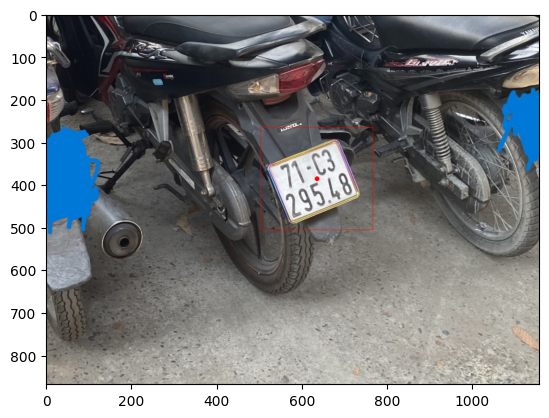

In [32]:
# import cv2 
# import matplotlib.pyplot as plt
# image_real = cv2.imread('../Image/dream_1.jpg')
# image_real = cv2.cvtColor(image_real, cv2.COLOR_RGB2BGR)
# plt.imshow(image_real)
# plt.axis('off')  # Tắt trục x và y
# plt.show()


# image = cv2.resize(image_real, (416, 416))
# image = image.astype(float)
# image = image/255
# image = np.expand_dims(image_real, axis=0)
# image.shape


# import cv2
# import matplotlib.pyplot as plt
# import numpy as np

# # Đọc và hiển thị hình ảnh gốc
# image_real = cv2.imread('D:\\Number Plate Region\\Full_Yolo\\Image_Test\\img_2.jpg')
# image_real = cv2.cvtColor(image_real, cv2.COLOR_BGR2RGB)  
# # Thay đổi kích thước hình ảnh
# resized_image = cv2.resize(image_real, (416, 416))
# resized_image = resized_image.astype(float)  # Chuyển đổi kiểu dữ liệu thành số thực
# resized_image /= 255  # Chuẩn hóa giá trị pixel về khoảng từ 0 đến 1

# # Mở rộng kích thước của hình ảnh để tạo batch
# image = np.expand_dims(resized_image, axis=0)
# prediction = yolo.model.predict(image)

# for i in range(len(image)):
#     x, y, w, h = yolo_data.vis_img(
#         image[i],
#         prediction[i],
#         conf_threshold=0.8,
#         nms_mode=2,
#         )
    

import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
image = cv2.imread("D:\\Number Plate Region\\Full_Yolo\\Image_Test\\img_150.jpg")
# image = cv2.imread("D:\\Number Plate Region\\Mydata\\ValImage\\0054_06642_b.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

resized_image = cv2.resize(image, (416, 416), interpolation = cv2.INTER_AREA)
image_pil = resized_image
resized_image = resized_image.astype(float) 
resized_image /= 255

img = np.expand_dims(resized_image, axis=0)
prediction = yolo.model.predict(img)

xywhcp = decode(prediction[0] , class_num=num_classes, threshold=0.5, version=2)
# print(xywhcp)
if len(xywhcp) > 0:
    xywhcp = soft_nms(xywhcp, num_classes, 0.5)

print(xywhcp)
idx = len(xywhcp) -1 

img_draw = Image.fromarray(image)
draw = ImageDraw.Draw(img_draw)
for i in range(len(xywhcp)):
    x = int(xywhcp[0][0] * image.shape[1])
    y = int(xywhcp[0][1] * image.shape[0])
    w = int(xywhcp[0][2] * image.shape[1]*1.3)
    h = int(xywhcp[0][3] * image.shape[0]*1.1)
    class_i = int(xywhcp[0][5])

    # Vẽ hình tròn
    radius = 5
    draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill='red')

    # Vẽ hình chữ nhật
    x_min, y_min = int(x - w / 2), int(y - h / 2)
    x_max, y_max = int(x + w / 2), int(y + h / 2)
    draw.rectangle([x_min, y_min, x_max, y_max], outline='red')

plt.imshow(img_draw)
plt.show()


In [33]:
# y = y * image_real.shape[0] / image[0].shape[0]
# h = h * image_real.shape[0] / image[0].shape[0]
# x = x * image_real.shape[1] / image[0].shape[1]
# w = w * image_real.shape[1] / image[0].shape[1]

# print(x, y, w, h)

In [34]:
# x_min = int(x - w/2)
# y_min = int(y - h/2)
# x_max = int(x + w/2)
# y_max = int(y + h/2)

# cropped_image = image_real[y_min:y_max, x_min:x_max]
# print(cropped_image.shape)
# plt.imshow(cropped_image)
# plt.axis('off')  # Tắt trục x và y
# plt.show()

In [35]:
# import cv2
# img_lp = cv2.resize(cropped_image, (320, 400))
# plt.imshow(img_lp)
# plt.axis('off')  # Tắt trục x và y
# plt.show()
# img_lp = cv2.convertScaleAbs(img_lp)
# img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
# _, img_binary_lp = cv2.threshold(img_gray_lp, 254, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# # img_binary_lp = cv2.erode(img_binary_lp, (15,15))
# img_binary_lp = cv2.dilate(img_binary_lp, (1,1))
# plt.imshow(img_binary_lp, cmap='gray')
# plt.axis('off')  # Tắt trục x và y
# plt.show()

In [36]:
# import cv2
# img_lp = cv2.resize(cropped_image, (400, 600))
# plt.imshow(img_lp)
# plt.axis('off')  # Tắt trục x và y
# plt.show()
# img_lp = cv2.convertScaleAbs(img_lp)
# img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
# _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# img_binary_lp = cv2.erode(img_binary_lp, (15,15))
# img_binary_lp = cv2.dilate(img_binary_lp, (15,15))
# # print(img_lp.shape)

# plt.imshow(img_binary_lp)
# plt.axis('off')  # Tắt trục x và y
# plt.show()

# LP_WIDTH = img_binary_lp.shape[1]
# LP_HEIGHT = img_binary_lp.shape[0]
# img_binary_lp[0:3,:] = 255
# img_binary_lp[:,0:3] = 255
# img_binary_lp[72:75,:] = 255
# img_binary_lp[:,330:333] = 255

# #estimations of character contours sizes of cropped license plates
# dimensions = [LP_WIDTH/15,
#                     LP_WIDTH/3,
#                     LP_HEIGHT/8,
#                     LP_HEIGHT/2]

# print(dimensions)

# cntrs, _ = cv2.findContours(img_binary_lp.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# # print(cntrs)
# #Approx dimensions of the contours
# lower_width = dimensions[0]
# upper_width = dimensions[1]
# lower_height = dimensions[2]
# upper_height = dimensions[3]

# #Check largest 15 contours for license plate character respectively
# cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

# # ci = cv2.imread('../Image/contour.jpg')

# x_cntr_list_1 = []
# x_cntr_list_2 = []
# target_contours = []
# img_res_1 = []
# img_res_2 = []


# for cntr in cntrs :
#     #detecting contour in binary image and returns the coordinates of rectangle enclosing it
#     intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
    
#     #checking the dimensions of the contour to filter out the characters by contour's size
#     if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height and intY < LP_HEIGHT/2 :
#         print(intX, intY, intWidth, intHeight)
#         x_cntr_list_1.append(intX) 
#         char_copy = np.zeros((44,24))
#         #extracting each character using the enclosing rectangle's coordinates.
#         char = img_binary_lp[intY:intY+intHeight, intX:intX+intWidth]
#         char = cv2.resize(char, (20, 40))
#         cv2.rectangle(img_binary_lp, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
#         plt.imshow(img_binary_lp, cmap='gray')
#         char = cv2.subtract(255, char)
#         char_copy[2:42, 2:22] = char
#         char_copy[0:2, :] = 0
#         char_copy[:, 0:2] = 0
#         char_copy[42:44, :] = 0
#         char_copy[:, 22:24] = 0
#         img_res_1.append(char_copy) # List that stores the character's binary image (unsorted)

# for cntr in cntrs :
#     #detecting contour in binary image and returns the coordinates of rectangle enclosing it
#     intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
#     if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height and intY > LP_HEIGHT/2 :
#         print(intX, intY, intWidth, intHeight)
#         x_cntr_list_2.append(intX) 
#         char_copy = np.zeros((44,24))
#         #extracting each character using the enclosing rectangle's coordinates.
#         char = img_binary_lp[intY:intY+intHeight, intX:intX+intWidth]
#         char = cv2.resize(char, (20, 40))
#         cv2.rectangle(img_binary_lp, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
#         plt.imshow(img_binary_lp, cmap='gray')
#         char = cv2.subtract(255, char)
#         char_copy[2:42, 2:22] = char
#         char_copy[0:2, :] = 0
#         char_copy[:, 0:2] = 0
#         char_copy[42:44, :] = 0
#         char_copy[:, 22:24] = 0
#         img_res_2.append(char_copy) # List that stores the character's binary image (unsorted)


# #return characters on ascending order with respect to the x-coordinate
        
# plt.show()
# #arbitrary function that stores sorted list of character indeces
# indices = sorted(range(len(x_cntr_list_1)), key=lambda k: x_cntr_list_1[k])
# # indices = sorted(range(len(x_cntr_list)), key=lambda k: (y_cntr_list[k], x_cntr_list[k]))
# img_res_copy = []
# for idx in indices:
#     img_res_copy.append(img_res_1[idx])# stores character images according to their index
# img_res_1 = np.array(img_res_copy)

# #arbitrary function that stores sorted list of character indeces
# indices = sorted(range(len(x_cntr_list_2)), key=lambda k: x_cntr_list_2[k])
# # indices = sorted(range(len(x_cntr_list)), key=lambda k: (y_cntr_list[k], x_cntr_list[k]))
# img_res_copy = []
# for idx in indices:
#     img_res_copy.append(img_res_2[idx])# stores character images according to their index
# img_res_2 = np.array(img_res_copy)

# img_res = np.concatenate((img_res_1, img_res_2), axis=0)

In [37]:
# for i in range(len(img_res)):
#     print(img_res[i].shape)
#     plt.imshow(img_res[i])
#     plt.axis('off')  # Tắt trục x và y
#     plt.show()

In [38]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# resized_image = cv2.resize(img_res[8], (28, 28))

# # Chuyển đổi độ sâu của hình ảnh sang định dạng 8-bit unsigned integer
# normalized_image = cv2.normalize(resized_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
# finalimage = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)

# plt.imshow(finalimage)
# plt.axis('off')
# plt.show()

In [39]:
# from keras.losses import SparseCategoricalCrossentropy
# from keras import datasets, layers, models
# import matplotlib.pyplot as plt
# def CNN_Model():
#     model = models.Sequential()
#     model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(64, (3, 3), activation='relu'))

#     model.add(layers.Flatten())
#     model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dense(36))

#     model.compile(optimizer='adam',
#                     loss=SparseCategoricalCrossentropy(from_logits=True),
#                     metrics=['accuracy'])
    
#     return model

# model_cnn=CNN_Model()

In [40]:
# model_cnn.load_weights("./cnn_number_1.h5")

In [41]:
# character = []
# for i in range(len(img_res)):
#     resized_image = cv2.resize(img_res[i], (28, 28))
#     # Chuyển đổi độ sâu của hình ảnh sang định dạng 8-bit unsigned integer
#     normalized_image = cv2.normalize(resized_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     finalimage = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)

#     image = finalimage
#     image_show = finalimage
#     image = np.expand_dims(image, axis=0)
#     predicts = model_cnn.predict(image)
#     predicted_class = np.argmax(predicts, axis=1)

#     if (predicted_class[0]) >= 10:
#         character.append(chr((predicted_class[0] - 10) + ord('A')))
#     else:
#         character.append(predicted_class[0])
#     print("Du Doan So Trong Hinh La: "+ str(predicted_class))
#     plt.subplot()
#     plt.imshow(image_show, cmap=plt.get_cmap('gray'))